In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
import requests
from keras.preprocessing.image import ImageDataGenerator
import splitfolders

In [2]:
cwd = os.getcwd()
origin_path = Path(cwd).parent.__str__()
dataset_path = os.path.sep.join((origin_path, "asset", "data", "dataset"))
images_path = os.path.sep.join((dataset_path, "images"))
train_path = os.path.sep.join((dataset_path, "train"))
test_path = os.path.sep.join((dataset_path, "test"))
files = os.listdir(os.path.sep.join((images_path, "0"))), os.listdir(os.path.sep.join((images_path, "1")))

## Function's declaration to:
Collect, load, generate, normalize, display and get stats of the data

In [3]:
def collect_data():
    """
    Used to collect more random images and increase the dataset
    """
    for i in tqdm(range(2000)):
        url = "https://picsum.photos/224/224/?random"
        response = requests.get(url)
        if response.status_code == 200:
            file_name = 'other_{}.jpg'.format(i)
            file_path = images_path + "other/" + file_name
            with open(file_path, 'wb') as f:
                f.write(response.content)

def show_augmented_vs_original():
    """
    Display original and augmented images
    """
    training_original.reset()
    training_augmented.reset()
    for i in range(2):
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 8), dpi=100)
        axes = axes.ravel()
        fig.suptitle("Original data" if i == 0 else "Augmented data", fontsize=13, y=.65)
        for ax in axes:
            if i == 0:
                image = next(training_original)[0][0]
            else:
                image = next(training_augmented)[0][0]
            ax.imshow(image/255)

In [6]:
# collect_data()
splitfolders.ratio(images_path, output=dataset_path, seed=777, ratio=(.6, 0.1, 0.3))

Copying files: 6107 files [00:04, 1325.05 files/s]


In [5]:
img_datagen_original = ImageDataGenerator()
img_datagen_augmented = ImageDataGenerator(rotation_range=40, horizontal_flip=True, vertical_flip=True, brightness_range=[.7, 1.3], zoom_range=.15, shear_range=0.15)

training_original = img_datagen_original.flow_from_directory(train_path, target_size=(224,224), classes=["1"], batch_size=1, shuffle=True)
training_augmented = img_datagen_augmented.flow_from_directory(train_path, target_size=(224,224), classes=["1"], batch_size=1, shuffle=True)

Found 1449 images belonging to 1 classes.
Found 1449 images belonging to 1 classes.


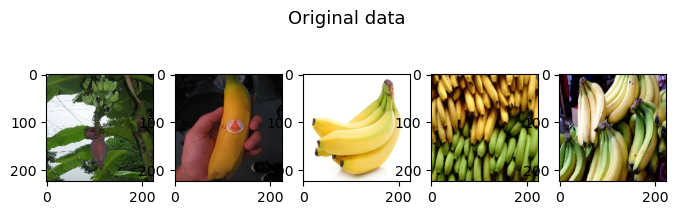

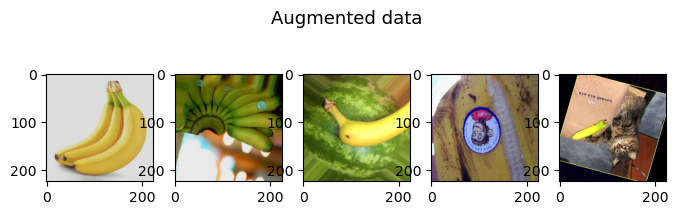

In [6]:
show_augmented_vs_original()